# Empirical Bayes for the Gaussian-Gaussian Hierarchical Model

A demonstration of how to estimate posterior group means in a Gaussian-Gaussian hierarchical model using Empirical Bayes. Based on Ch 5 of Murphy, Machine Learning.

Author: Juvid Aryaman


In [1]:
import numpy as np
import pandas as pd
import utls
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
utls.reset_plots()

Assume that the score ($x_{ij}$) of every student $i = 1,\dots,N_j$ from school $j=1,\dots,D$ is Gaussian distributed according to

$$p(x_{ij}|\theta_j,\sigma^2) = \mathcal{N}(x_{ij}|\theta_j,\sigma^2).$$

We assume that $\sigma$ is the same for every school (this assumption allows us to write down an Emperical Bayes solution in closed form, otherwise we need to use expectation maximization), and is known for simplicity. Our prior for $\theta_j$ is also Gaussian:

$$p(\theta_j|\mu,\tau^2) = \mathcal{N}(\theta_j| \mu, \tau^2).$$ 

Hence we have a graphical model which looks like this:

![](Figures/EB.png)

where $\boldsymbol{\eta} = (\mu,\tau)$. 

Aim: To estimate $\theta_j$ for every school. 

Let's generate synthetic data from the process

In [3]:
np.random.seed(1)
mu_true = 7.0 # inter-school mean score
tau_sq_true = 0.6 # inter-school score variance
n_schools = 18
#n_schools = 2000

theta_j = np.random.normal(mu_true, np.sqrt(tau_sq_true), n_schools) # mean score per school

ndata_per_school = np.random.randint(12,20,n_schools)

sigma_true = 0.7 # intra-school score variability

data = []

for j in range(n_schools):
    data_j = np.random.normal(theta_j[j], sigma_true, ndata_per_school[j])
    data.append(np.array(data_j))

Visualise data

/home/juvid/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


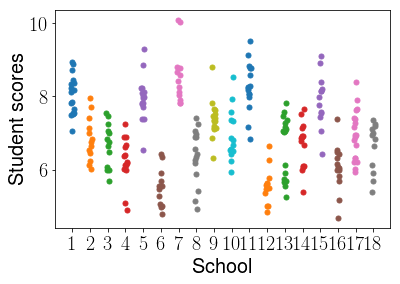

In [4]:
fig, ax = plt.subplots(1,1)
for j in range(n_schools):
    data_j = data[j]
    n = ndata_per_school[j]
    x_coords = np.ones(n)*(j+1) + np.random.uniform(-0.1,0.1,n)
    ax.plot(x_coords, data_j,'.')

ax.set_xticks(np.arange(1,n_schools+1))
ax.set_xlabel('School')
ax.set_ylabel('Student scores');

The obvious choice is to take 

$$\hat{\theta}_j = \frac{1}{N_j}\sum_i x_{ij}$$

for every school, which is the maximum likelihood estimate. Can we do better, given our knowledge of the model structure?

For this model, we have 

$$p(\boldsymbol{\theta},\mathcal{D}|\boldsymbol{\eta},\sigma^2) = \prod_{j=1}^D \mathcal{N}(\theta_j | \mu,\tau^2) \prod_{i=1}^{N_j}\mathcal{N}(x_{ij}|\theta_j,\sigma^2).$$

One can show the following marginal likelihood (Eq 5.91 of Murphy)

$$p(\mathcal{D}|\mu,\tau^2,\sigma^2) = \prod_{j=1}^D \mathcal{N}(\bar{x}_j | \mu, \tau^2 + \sigma^2)$$

where $\bar{x}_j = \sum_{i=1}^{N_j} x_{ij}$. 

The crucial step in Empirical Bayes is for our priors to be informed by the data in the following way. We take maximum likelihood estimates of the marginal likelihood for the hyperparameters $\mu$ and $\tau$, arriving at

$$\hat{\mu} = \frac{1}{D} \sum_{j=1}^{D} \bar{x}_j = \bar{x}$$

$$\hat{\tau}^2 + \sigma^2 = \frac{1}{D-1}\sum_{j=1}^D(\bar{x}_j - \bar{x})^2.$$

Empirical Bayes violates the principle that the prior should be chosen independently of the data. We just view this as a computationally cheap approximation to inference in a hierarchical Bayesian model.

Given our estimates $\hat{\mu}$ and $\hat{\tau}$, we may write

$$p(\boldsymbol{\theta},\mathcal{D}|\hat{\boldsymbol{\eta}},\sigma^2) = \prod_{j=1}^D \mathcal{N}(\theta_j | \hat{\mu},\hat{\tau}^2) \mathcal{N}(\bar{x}|\theta_j,\sigma^2/N_j)$$

where we've used the trick that $N_j$ independent measurements of a Gaussian with variance $\sigma$ is the same as one measurement at the sample mean with variance $\sigma_j^2 := \sigma^2/N_j$.

Using Bayes rule for linear Gaussian systems (Sec 4.4.1 of Murphy), we may write 

$$p(\theta_j|\mathcal{D},\hat{\mu},\hat{\tau}^2, \sigma) = \mathcal{N}(\theta_j|\hat{B}_j \hat{\mu} + (1-\hat{B}_j) \bar{x}_j,(1-\hat{B}_j) \sigma_j)$$

$$\hat{B}_j = \frac{\sigma^2_j}{\sigma^2_j + \hat{\tau}^2}$$

In [5]:
xbar_j = np.array([np.mean(data[j]) for j in range(n_schools)])
mu_hat = np.mean(xbar_j)
tau_sq_hat = max(0,np.var(xbar_j,ddof=1) - sigma_true**2)

In [6]:
sigma_j = np.sqrt(sigma_true/ndata_per_school)
B_hat_j = sigma_j**2/(sigma_j**2 + tau_sq_hat)
theta_j_EB = B_hat_j*mu_hat + (1.-B_hat_j)*xbar_j

Visualise errors

In [7]:
res_EB = (theta_j - theta_j_EB)**2
res_ML = (theta_j - xbar_j)**2

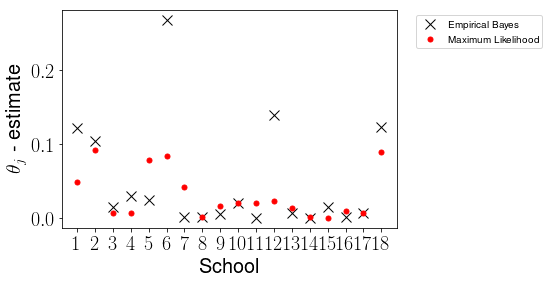

In [8]:
fig, ax = plt.subplots(1,1)
x = np.arange(1,n_schools+1)

ax.plot(x,res_EB,'kx',label = 'Empirical Bayes')
ax.plot(x,res_ML,'r.', label = 'Maximum Likelihood')


ax.set_xticks(x)
ax.set_xlabel('School')
ax.set_ylabel(r'$\theta_j$ - estimate')
ax.legend(prop={'size':10},bbox_to_anchor=(1.45, 1.0));

In [9]:
cm = plt.get_cmap("jet")
cols = cm((0.5+np.arange(0,n_schools))/float(n_schools))

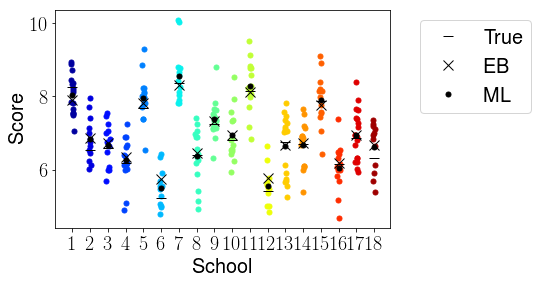

In [10]:
fig, ax = plt.subplots(1,1)
x = np.arange(1,n_schools+1)

for j in range(n_schools):
    data_j = data[j]
    n = ndata_per_school[j]
    x_coords = np.ones(n)*(j+1) + np.random.uniform(-0.1,0.1,n)
    ax.plot(x_coords, data_j,'.',color=cols[j])
    eb=ax.plot(j+1, theta_j_EB[j], 'x',color='k')
    ml=ax.plot(j+1, xbar_j[j], '.',color='k')
    tr=ax.plot(j+1, theta_j[j], '_',color='k')

ax.legend((tr[0],eb[0],ml[0]),('True','EB','ML'),bbox_to_anchor=(1.45, 1.0))
ax.set_xticks(x)
ax.set_xlabel('School')
ax.set_ylabel(r'Score');


In [11]:
np.sum(res_EB)/n_schools,np.sum(res_ML)/n_schools

(0.04884531118993168, 0.030930514717019637)

Hmmm, in this case it doesn't seem to be doing better than MLE.

To do: 

- Debug?
- If correct, under what circumstances do we expect this to perform better than MLE? The key advantage seems to be being able to learn what $\mu$ and $\tau$ are. In the limit of large $D$ does this perform well? Seems not after a quick play....